# Priorización de Llamadas en Contact Center con IA

**Alumnos:** Camila Codina, Isabella Marafioti, Luca Sucri, Luciano Esteban y Martin Garcia

### El Problema
Uno de nuestros compañeros trabaja en el área de Contact Center (B2C) para una empresa de telecomunicaciones y nos comentó un desafío común: la alta demanda de llamadas y la dificultad para priorizar a los clientes que requieren atención inmediata. Un cliente enojado o muy angustiado que espera demasiado tiempo puede resultar en la pérdida del cliente.

### La Solución
Buscamos solucionar esto implementando un sistema de Reconocimiento de Emociones en la Voz (Speech Emotion Recognition - SER) que analice los primeros segundos del audio de cada usuario en la cola de espera.

El objetivo es clasificar la emoción del hablante (ej. "enojado", "triste", etc.) y asignar automáticamente un nivel de prioridad a la llamada.

### El Conjunto de Datos: RAVDESS
Utilizaremos el conjunto de datos RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song).

**Archivos**: 1440 archivos de audio.

**Actores**: 24 actores profesionales (12 hombres, 12 mujeres).

**Emociones**: 8 emociones identificadas: neutral, calma, feliz, triste, enojado, temeroso, disgusto, sorprendido.

**Formato de Archivo**: La emoción está identificada por el tercer número en el nombre del archivo (ej. 03-01-**05**-.. sería 'enojado').


***Prerequisitos***:
1. Crear una cuenta en Kaggle.
2. En el botón superior derecho de "Mi Perfil", selecciona Settings.
3. En la sección API, genera un nuevo token. Esto descarga un archivo kaggle.json.
4. Subi el archivo kaggle.json a Collab.

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from scipy.io.wavfile import write
import warnings
import random

from fastai.vision.all import *

warnings.filterwarnings('ignore')


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download uwrfkaggler/ravdess-emotional-speech-audio

print("Descomprimiendo el dataset...")
!unzip -q ravdess-emotional-speech-audio.zip -d audio-dataset
print("¡Dataset listo!")

# Verifiquemos que están los archivos
!ls audio-dataset

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 96% 414M/429M [00:06<00:00, 67.0MB/s]
100% 429M/429M [00:06<00:00, 73.7MB/s]
Descomprimiendo el dataset...
replace audio-dataset/Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y A
replace audio-dataset/Actor_01/03-01-01-01-01-02-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y
¡Dataset listo!
Actor_01  Actor_06  Actor_11  Actor_16	Actor_21
Actor_02  Actor_07  Actor_12  Actor_17	Actor_22
Actor_03  Actor_08  Actor_13  Actor_18	Actor_23
Actor_04  Actor_09  Actor_14  Actor_19	Actor_24
Actor_05  Actor_10  Actor_15  Actor_20	audio_speech_actors_01-24


In [7]:
# Establecemos prioridades

def get_priority(emotion):
    """ Asigna un nivel de prioridad basado en la emoción detectada. """
    if emotion in ['angry', 'fearful', 'disgust']:
        return "ALTA PRIORIDAD (Transferencia inmediata)"
    elif emotion in ['sad', 'surprised']:
        return "PRIORIDAD MEDIA (Marcar para seguimiento)"
    else: # happy, calm, neutral
        return "PRIORIDAD BAJA (Cola estándar)"

BASE_PATH = Path.cwd()
AUDIO_PATH = BASE_PATH / 'audio-dataset'
IMAGE_PATH = BASE_PATH / 'spectrograms'

emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

print("Variables y función de prioridad definidas.")

Variables y función de prioridad definidas.


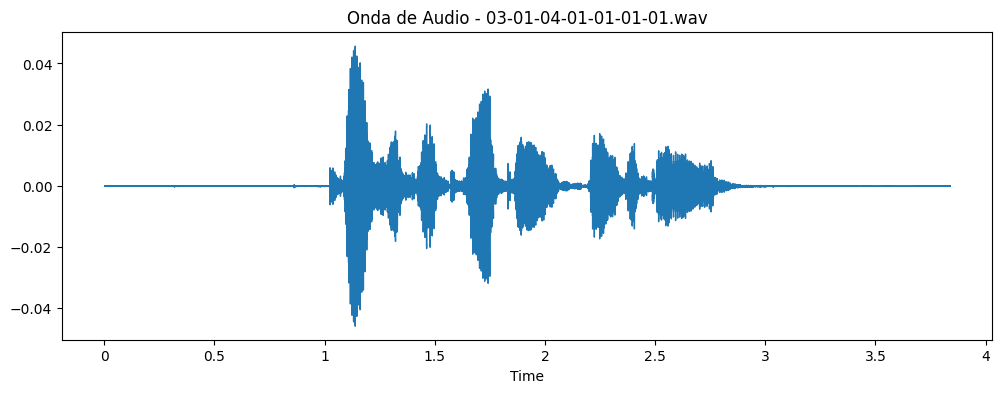

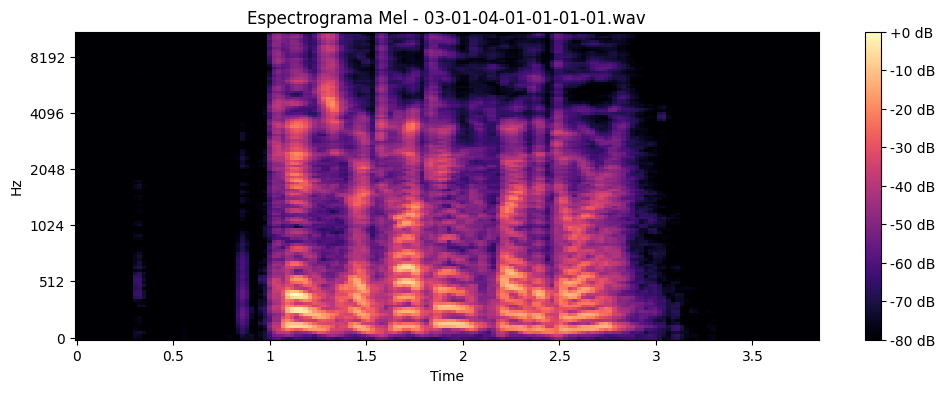

In [8]:
# Cargar un archivo de muestra
sample_file = list(AUDIO_PATH.glob('Actor_01/*.wav'))[0]
y, sr = librosa.load(sample_file)

# 1. Gráfico de la Onda (Waveplot)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f'Onda de Audio - {sample_file.name}')
plt.show()

# 2. Gráfico del Espectrograma Mel
# Esta es la "imagen" que usará nuestro modelo de Visión Computacional
D = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.power_to_db(D, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Espectrograma Mel - {sample_file.name}')
plt.show()

In [9]:
os.makedirs(IMAGE_PATH, exist_ok=True)

all_audio_files = list(AUDIO_PATH.glob('*/*.wav'))
processed_count = 0

for file_path in all_audio_files:
    try:
        # Extraer el código de emoción del nombre del archivo
        emotion_code = file_path.name.split('-')[2]
        emotion = emotion_dict.get(emotion_code)

        if not emotion:
            continue

        # Crear la carpeta para la emoción (ej. 'spectrograms/angry')
        emotion_folder = IMAGE_PATH / emotion
        os.makedirs(emotion_folder, exist_ok=True)

        # Definir el nombre del archivo de salida
        output_file = emotion_folder / f'{file_path.stem}.jpg'

        # Cargar el audio y recortar silencios
        y, sr = librosa.load(file_path)
        y_trimmed, _ = librosa.effects.trim(y, top_db=25)

        # Generar espectrograma Mel
        D = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=128)
        S_db = librosa.power_to_db(D, ref=np.max)

        # Guardar el espectrograma como imagen
        # Desactivamos ejes y bordes para que la imagen sea "pura"
        plt.figure(figsize=(4, 3))
        librosa.display.specshow(S_db, sr=sr)
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
        plt.close()
        processed_count += 1

    except Exception as e:
        print(f"Error procesando {file_path}: {e}")

print(f"Preprocesamiento completado. {processed_count} espectrogramas guardados.")

Preprocesamiento completado. 1440 espectrogramas guardados.



Clases detectadas: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


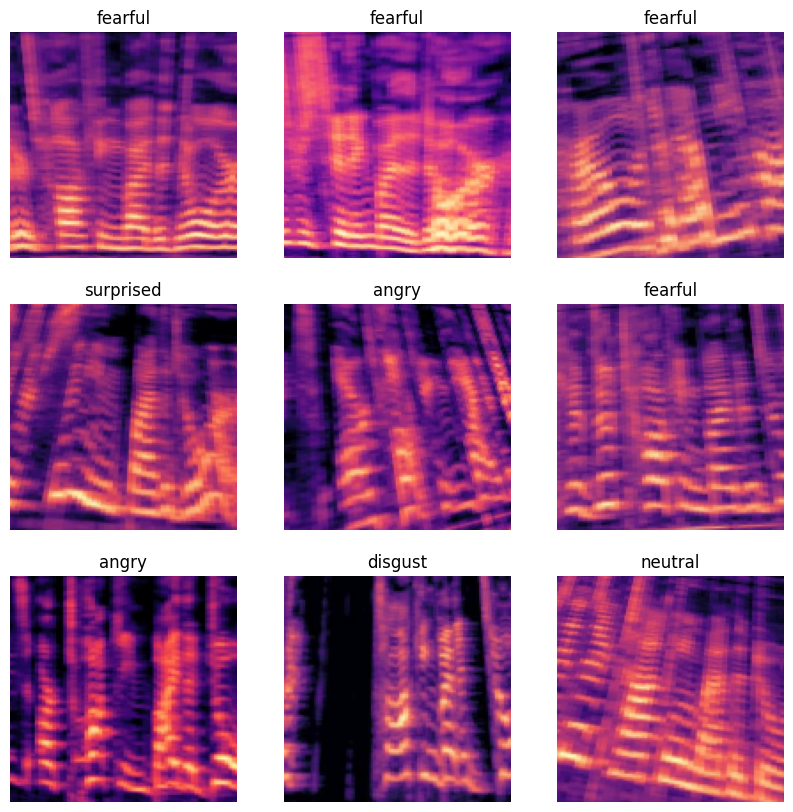

In [10]:
# Asignamos 30% de los datos para validación (valid_pct=0.3)
dls = ImageDataLoaders.from_folder(
    IMAGE_PATH,
    valid_pct=0.3,  # <-- 30% para el Test/Validation set
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=128),
    seed=42, # 'seed' asegura que la división sea reproducible
    num_workers=0
)

# Revisamos las clases (las carpetas que encontró)
print("\nClases detectadas:", dls.vocab)

# Mostramos un lote (batch) de datos de entrenamiento
dls.show_batch(figsize=(10, 10))

In [11]:
# Creamos el 'learner' usando un modelo resnet34 pre-entrenado
learn = cnn_learner(
    dls,
    resnet34,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy
)

# Buscamos la tasa de aprendizaje óptima (opcional pero recomendado)
# lr_steep = learn.lr_find(show_plot=True)
# print(f"Tasa de aprendizaje sugerida: {lr_steep.steepest:.2e}")

# Entrenamos por 8 épocas usando una tasa de aprendizaje estándar
# (Usar 1e-3 o 3e-3 suele ser un buen punto de partida si se salta lr_find)
learn.fit_one_cycle(8, 3e-3)

print("Entrenamiento finalizado.")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 387MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,3.157997,2.080935,0.247685,01:27
1,2.910035,1.941194,0.340278,01:27
2,2.657735,1.910474,0.409722,01:26
3,2.486996,1.867365,0.379630,01:28
4,2.335342,1.747425,0.414352,01:31
5,2.169449,1.649908,0.430556,01:30
6,2.057793,1.596854,0.446759,01:28
7,1.968034,1.582842,0.458333,01:28


Entrenamiento finalizado.


Matriz de Confusión (Real vs. Predicción):


Modelo exportado a /content/contact_center_model.pkl


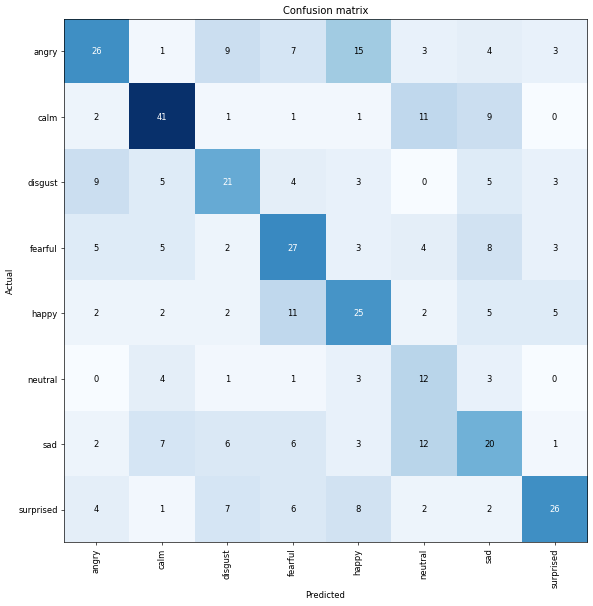

In [12]:
# Creamos un objeto de interpretación
interp = ClassificationInterpretation.from_learner(learn)

# Trazamos la matriz de confusión
print("Matriz de Confusión (Real vs. Predicción):")
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)

# Exportamos el modelo entrenado
MODEL_EXPORT_PATH = BASE_PATH / 'contact_center_model.pkl'
learn.export(MODEL_EXPORT_PATH)
print(f"Modelo exportado a {MODEL_EXPORT_PATH}")

In [13]:
# Cargamos el modelo que acabamos de guardar
model = load_learner(MODEL_EXPORT_PATH)
print("Modelo de priorización cargado.")

# --- Función de procesamiento de audio individual ---
def process_single_audio_for_prediction(file_path, img_path):
    """ Convierte un único archivo de audio en un espectrograma listo para el modelo. """
    try:
        y, sr = librosa.load(file_path)
        y_trimmed, _ = librosa.effects.trim(y, top_db=25)

        D = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=128)
        S_db = librosa.power_to_db(D, ref=np.max)

        plt.figure(figsize=(4, 3))
        librosa.display.specshow(S_db, sr=sr)
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.savefig(img_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        return True
    except Exception as e:
        print(f"Error procesando audio: {e}")
        return False

# --- Función principal de simulación ---
def simulate_call_priority():
    """
    Simula la recepción de una llamada:
    1. Elige un audio de prueba al azar.
    2. Lo procesa.
    3. Predice la emoción.
    4. Asigna prioridad.
    """

    temp_img_file = BASE_PATH / 'temp_call_spectrogram.jpg'

    print("\n--- [SIM] NUEVA LLAMADA ENTRANTE ---")

    # Elegimos un audio al azar de nuestro dataset completo
    all_audio_files = list(AUDIO_PATH.glob('*/*.wav'))
    random_audio_file = random.choice(all_audio_files)

    # Obtenemos la emoción real para comparar
    real_emotion_code = random_audio_file.name.split('-')[2]
    real_emotion = emotion_dict.get(real_emotion_code)

    print(f"Archivo de audio: {random_audio_file.name}")
    print(f"Emoción REAL del archivo: {real_emotion.upper()}")

    # Procesar el audio a espectrograma
    if not process_single_audio_for_prediction(random_audio_file, temp_img_file):
        return

    # Cargar la imagen para la predicción
    img = PILImage.create(temp_img_file)

    # Predecir la emoción
    emotion, _, probs = model.predict(img)
    confidence = float(probs.max())

    # Obtener prioridad
    priority = get_priority(str(emotion))

    # Mostrar resultados de la simulación
    print("\n--- [IA] RESULTADO DE LA PRIORIZACIÓN ---")
    print(f"Emoción Detectada: {str(emotion).upper()} (Confianza: {confidence:.2f})")
    print(f"Nivel de Prioridad: {priority}")
    print("--------------------------------------\n")

    # Limpiar archivo temporal
    os.remove(temp_img_file)

print("Funciones de simulación listas.")

Modelo de priorización cargado.
Funciones de simulación listas.


In [20]:
simulate_call_priority()


--- [SIM] NUEVA LLAMADA ENTRANTE ---
Archivo de audio: 03-01-03-02-01-01-03.wav
Emoción REAL del archivo: HAPPY



--- [IA] RESULTADO DE LA PRIORIZACIÓN ---
Emoción Detectada: HAPPY (Confianza: 0.36)
Nivel de Prioridad: PRIORIDAD BAJA (Cola estándar)
--------------------------------------



In [22]:
simulate_call_priority()


--- [SIM] NUEVA LLAMADA ENTRANTE ---
Archivo de audio: 03-01-07-01-02-02-17.wav
Emoción REAL del archivo: DISGUST



--- [IA] RESULTADO DE LA PRIORIZACIÓN ---
Emoción Detectada: DISGUST (Confianza: 0.49)
Nivel de Prioridad: ALTA PRIORIDAD (Transferencia inmediata)
--------------------------------------

